In [29]:
# Uncomment below if you want to run this file only
%run main.ipynb
#%run data_cleaning.ipynb
#%run data_visualization.ipynb
#%run feature_engineering.ipynb

In [30]:
# Read the CSV From FEATURE ENGINEERING data source file from S3 into a DataFrame
# Use the methods from the S3Utils class
if s3_utils.check_file_exists(output_file_key_data_feature_engineering):
    dataset = s3_utils.read_csv_from_s3(output_file_key_data_feature_engineering)

In [31]:
#import libraries
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [32]:
dataset['target'].value_counts()

target
0    326265
1     28925
Name: count, dtype: int64

We will conduct a clustering analysis on the population subset with target=1, representing individuals who churn. Following the algorithm, we'll perform a comprehensive analysis and generate actionable recommendations based on the clustered data.

In [33]:
# Filter the DataFrame to include only rows where the target variable=1
df = dataset[dataset['target'] == 1]
df.shape

(28925, 22)

In [34]:
df.head(2)

,id,amount_rub_clo_prc,amount_rub_sup_prc,rest_dynamic_save_3m,rest_avg_cur,amount_rub_nas_prc,amount_rub_atm_prc,rest_dynamic_fdep_3m,rest_avg_paym,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,rest_dynamic_paym_3m,rest_dynamic_il_3m,rest_dynamic_cc_3m,target,pack_encoded,number_products,new_age_category_numeric,new_setup_tenor,total_turnover_category,total_turnover_1m_category,total_turnover_3m_category
26,146871,0.020267,0.111424,0.994683,1049.544317,0.0,0.000000,0.0,0.0,0.0,0.597867,0.0,0.0,0.0,1,11,1,1,0.484866,0,4,4
27,146872,0.000000,0.016017,0.000000,372.021867,0.0,0.983983,0.0,0.0,0.0,0.929992,0.0,0.0,0.0,1,1,2,1,1.084999,0,4,4


In [35]:
df.isnull().sum()

id                               0
amount_rub_clo_prc            2432
amount_rub_sup_prc            2432
rest_dynamic_save_3m             0
rest_avg_cur                     0
amount_rub_nas_prc            2432
amount_rub_atm_prc            2432
rest_dynamic_fdep_3m             0
rest_avg_paym                    0
ldeal_grace_days_pct_med         0
rest_dynamic_cur_3m              0
rest_dynamic_paym_3m             0
rest_dynamic_il_3m               0
rest_dynamic_cc_3m               0
target                           0
pack_encoded                     0
number_products                  0
new_age_category_numeric         0
new_setup_tenor                  0
total_turnover_category          0
total_turnover_1m_category       0
total_turnover_3m_category       0
dtype: int64

In [36]:
# Columns with missing values
cols_with_missing = ['amount_rub_clo_prc', 'amount_rub_sup_prc', 
                     'amount_rub_nas_prc', 'amount_rub_atm_prc']

# Impute missing values with mean
for col in cols_with_missing:
    # Fill missing values with the mean of each column using .loc
    df.loc[:, col] = df[col].fillna(df[col].mean())

### Clustering Algorithm: K-Means

In [55]:
from sklearn.preprocessing import MinMaxScaler

# Drop the target variable column to get feature data
X = df.drop(columns=['target'])

# Extract the columns that need scaling
columns_to_scale = ['amount_rub_clo_prc', 'amount_rub_sup_prc', 'rest_dynamic_save_3m', 'rest_avg_cur',
                    'amount_rub_nas_prc', 'amount_rub_atm_prc', 'rest_dynamic_fdep_3m', 'rest_avg_paym',
                    'ldeal_grace_days_pct_med', 'rest_dynamic_cur_3m', 'rest_dynamic_paym_3m', 'rest_dynamic_il_3m',
                    'rest_dynamic_cc_3m', 'number_products', 'new_age_category_numeric', 'new_setup_tenor',
                    'total_turnover_category', 'total_turnover_1m_category', 'total_turnover_3m_category']

# Apply Min-Max scaling to the selected columns
scaler = MinMaxScaler()
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])

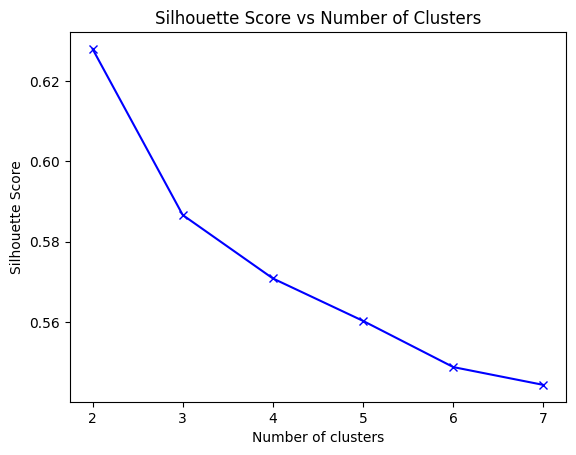

In [56]:
# Calculate the silhouette score to choose the best number of clusters for our model

# Determining the range of clusters (let's say from 2 to 10 clusters)
k_values = range(2, 8)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, labels))

# Plotting the silhouette scores
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

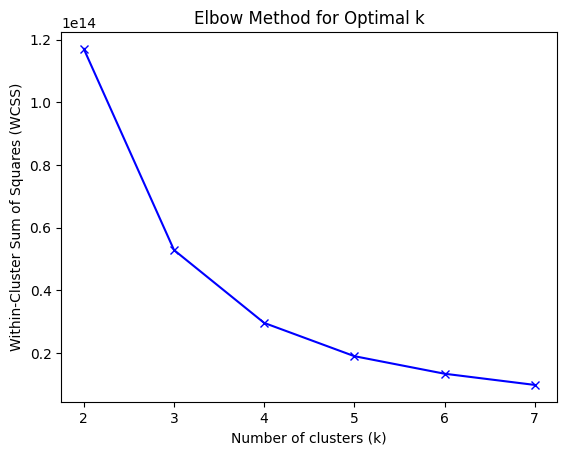

In [57]:
#Using the Elbow Method
# Determine the range of clusters (let's say from 2 to 10 clusters)
k_values = range(2, 8)
wcss_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss_values.append(kmeans.inertia_)  # inertia_ gives WCSS

# Plotting the elbow curve
plt.plot(k_values, wcss_values, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [60]:
# Assign the number of clusters
k = 2
# Set random state to allow reproducibility
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)
# Calculate Silhoutte Score
score = silhouette_score(X, kmeans.labels_, metric='euclidean')
# Print the score
print('Silhouetter Score: %.3f' % score)
# Calculate the Calinsky Harabasz Score
ch_score = calinski_harabasz_score(X, kmeans.labels_)
# Print the score
print('Calinsky Harabasz Score: %.3f' % ch_score)

Silhouetter Score: 0.628
Calinsky Harabasz Score: 87051.091


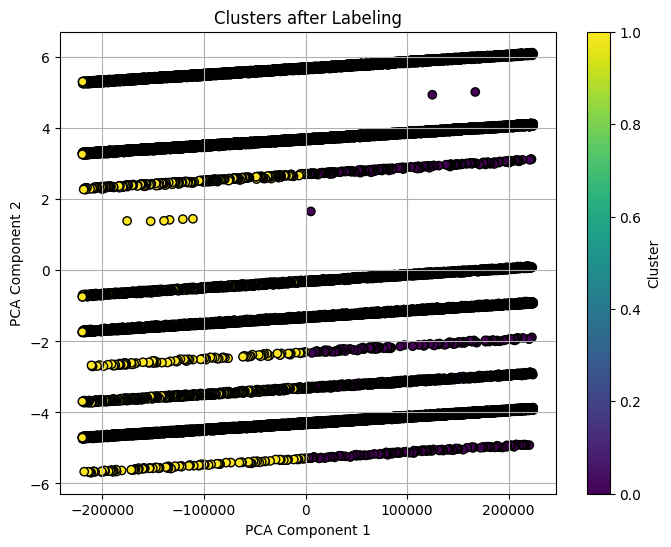

In [74]:
from sklearn.decomposition import PCA
# Choose the optimal number of clusters based on the plot or other metrics
optimal_num_clusters = 2 

# Apply K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=42)
kmeans.fit(X)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Optionally, you can add cluster labels as a feature in your dataset
X['cluster_label'] = cluster_labels

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters after Labeling')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [78]:
# Descriptive summary of clusters

X['cluster_label'] = kmeans.labels_
labels = list(set(kmeans.labels_))
labels

[0, 1]

In [81]:
for label in np.unique(cluster_labels):
    print('\nCluster {}:'.format(label))
    cluster_instances = X[cluster_labels == label]
    print('Number of Instances: {}'.format(cluster_instances.shape[0]))
    display(cluster_instances.describe())


Cluster 0:
Number of Instances: 14201


,id,amount_rub_clo_prc,amount_rub_sup_prc,rest_dynamic_save_3m,rest_avg_cur,amount_rub_nas_prc,amount_rub_atm_prc,rest_dynamic_fdep_3m,rest_avg_paym,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,rest_dynamic_paym_3m,rest_dynamic_il_3m,rest_dynamic_cc_3m,pack_encoded,number_products,new_age_category_numeric,new_setup_tenor,total_turnover_category,total_turnover_1m_category,total_turnover_3m_category,cluster_label
count,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.000000,14201.0,14201.000000,14201.000000,14201.0
mean,258665.547637,0.029237,0.072380,0.073818,0.005612,0.020137,0.694880,0.006909,0.001354,0.001309,0.478017,0.110024,0.006211,0.005300,5.062953,0.035420,0.533308,0.237138,0.0,0.543060,0.549299,0.0
std,63671.221978,0.089849,0.134592,0.228207,0.020402,0.081250,0.332337,0.060934,0.010766,0.032208,0.365779,0.244453,0.062985,0.057692,3.755650,0.064576,0.138337,0.180220,0.0,0.365544,0.369031,0.0
min,146871.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004550,0.0,0.000000,0.000000,0.0
25%,204835.000000,0.000000,0.000000,0.000000,0.000195,0.000000,0.507549,0.000000,0.000000,0.000000,0.124425,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000,0.086927,0.0,0.200000,0.200000,0.0
50%,258963.000000,0.000000,0.016388,0.000000,0.001145,0.000000,0.793506,0.000000,0.000000,0.000000,0.454110,0.000000,0.000000,0.000000,4.000000,0.000000,0.500000,0.189280,0.0,0.600000,0.600000,0.0
75%,313564.000000,0.027882,0.073145,0.000000,0.004535,0.012650,0.994415,0.000000,0.000000,0.000000,0.838289,0.000000,0.000000,0.000000,9.000000,0.062500,0.500000,0.349873,0.0,1.000000,1.000000,0.0
max,369095.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,0.937500,1.000000,0.978869,0.0,1.000000,1.000000,0.0



Cluster 1:
Number of Instances: 14724


,id,amount_rub_clo_prc,amount_rub_sup_prc,rest_dynamic_save_3m,rest_avg_cur,amount_rub_nas_prc,amount_rub_atm_prc,rest_dynamic_fdep_3m,rest_avg_paym,ldeal_grace_days_pct_med,rest_dynamic_cur_3m,rest_dynamic_paym_3m,rest_dynamic_il_3m,rest_dynamic_cc_3m,pack_encoded,number_products,new_age_category_numeric,new_setup_tenor,total_turnover_category,total_turnover_1m_category,total_turnover_3m_category,cluster_label
count,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.000000,14724.0,14724.000000,14724.000000,14724.0
mean,479375.919180,0.028026,0.073883,0.072705,0.005221,0.020862,0.696041,0.008126,0.001120,0.001233,0.504894,0.114180,0.005928,0.004738,5.547609,0.033487,0.537320,0.221690,0.0,0.575998,0.594852,1.0
std,63535.321994,0.085940,0.135086,0.225431,0.017968,0.086657,0.331528,0.067979,0.005097,0.031916,0.372451,0.252497,0.062566,0.055650,3.817757,0.063107,0.143633,0.181401,0.0,0.361718,0.361080,0.0
min,369126.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
25%,425234.000000,0.000000,0.000000,0.000000,0.000198,0.000000,0.509173,0.000000,0.000000,0.000000,0.151460,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000,0.068096,0.0,0.200000,0.200000,1.0
50%,478530.500000,0.000000,0.017970,0.000000,0.001083,0.000000,0.797893,0.000000,0.000000,0.000000,0.479475,0.000000,0.000000,0.000000,4.000000,0.000000,0.500000,0.171816,0.0,0.600000,0.600000,1.0
75%,533154.250000,0.028092,0.075022,0.000000,0.004031,0.012516,0.995374,0.000000,0.000000,0.000000,0.923000,0.000000,0.000000,0.000000,9.000000,0.062500,0.500000,0.336834,0.0,1.000000,1.000000,1.0
max,590828.000000,1.000000,1.000000,1.000000,0.604081,1.000000,1.000000,1.000000,0.132474,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.0


#### Recomendations Cluster 0

#### Recomendations Cluster 1